In [1]:
%matplotlib inline



# Fitting Robinson model (Tepit data)


In [2]:
#cd /external/rprshnas01/netdata_kcni/jglab/MemberSpaces/tm/git/whobpyt

## Importage




In [3]:
# os stuff
import os
import sys
sys.path.append('..')

#import gdown
import matplotlib.pyplot as plt
# import scipy.io
import pandas as pd
import numpy as np
from whobpyt.optimization.custom_cost_JR import CostsJR
from whobpyt.optimization.modelfitting import Model_fitting
from whobpyt.models.Robinson.robinson import RNNROBINSON
from whobpyt.models.Robinson.ParamsCT import ParamsCT
from whobpyt.datatypes.parameter import par
from whobpyt.data.dataload import dataloader
import whobpyt


# whobpyt stuff

# array and pd stuff


# viz stuff

# gdown


define destination path and download data



In [4]:
#cd examples

In [5]:
des_dir = '../'
if not os.path.exists(des_dir):
    os.makedirs(des_dir)  # create folder if it does not exist
url = 'https://drive.google.com/drive/folders/1uXrtehuMlLBvPCV8zDaUYxF-MoMaD0fk'
os.chdir(des_dir)
# gdown.download_folder(url, quiet = True, use_cookies = False)
os.chdir('examples/')

get  EEG data



In [6]:
base_dir = '../Tepit/'
eeg_file = base_dir + 'eeg_data.npy'
eeg_data_all = np.load(eeg_file)
eeg_data = eeg_data_all.mean(0)

eeg_data = eeg_data[:, 700:1100] / 12*50


In [7]:
eeg_data


array([[ 2.36228259,  2.42274257,  2.48488617, ...,  2.6274691 ,
         2.00343176,  1.46210307],
       [ 1.10218536,  1.17014697,  1.1853628 , ...,  0.10279411,
        -0.42389459, -0.86431988],
       [ 2.22638001,  2.3500591 ,  2.43390133, ...,  3.49687409,
         2.8567976 ,  2.32431131],
       ...,
       [-2.34982001, -2.74432963, -3.05945711, ..., -7.52871697,
        -6.86503405, -6.37351939],
       [-2.08383656, -2.47166018, -2.81480283, ..., -5.87637781,
        -5.29003672, -4.86927024],
       [-2.33695931, -2.67794133, -2.98236018, ..., -4.08238285,
        -3.66871973, -3.34924207]])

get stimulus weights on regions



In [8]:
ki0 = np.loadtxt(base_dir + 'stim_weights.txt')[:, np.newaxis]


get SC and distance template



In [9]:
sc_file = base_dir + 'Schaefer2018_200Parcels_7Networks_count.csv'
dist_file = base_dir + 'Schaefer2018_200Parcels_7Networks_distance.csv'
sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values
dist_df = pd.read_csv(dist_file, header=None, sep=' ')
dist = dist_df.values
sc = np.log1p(sc) / np.linalg.norm(np.log1p(sc))


define options for Robinson model



In [10]:
node_size = sc.shape[0]

output_size = eeg_data.shape[0]
batch_size = 20
step_size = 1e-7
num_epoches = 30
tr = 1e-6
state_size = 16
base_batch_num = 20
time_dim = 400

hidden_size = int(tr/step_size)


prepare data structure of the model



In [11]:
data_mean = dataloader(eeg_data.T, num_epoches, batch_size)


get model parameters structure and define the fitted parameters by setting non-zero variance for the model



In [12]:
lm = np.zeros((output_size, 200))
lm_v = np.zeros((output_size, 200))
par = ParamsCT(nu_ee=par(0.0528/1000, 0.0528/1000, 0.00001, True, True), 
               nu_ii=par(0.0528/1000, 0.0528/1000, 0.00001, True, True), 
               nu_ei=par(0.228/1000, 0.228/1000, 0.00001, True, True), 
               lm=par(lm, lm, 1.0 * np.ones((output_size, 200))+lm_v, True, True),  
               # k = [10, .3],
               # cy0 = [5, 0], ki=[ki0, 0], k_aud=[k_aud0, 0], lm=[lm, 1.0 * np.ones((output_size, 200))+lm_v], \
               g=par(100), 
               cy0=par(5, 5, 0.5, True, True))


In [13]:
sc.shape


(200, 200)

call model want to fit



In [14]:
model = RNNROBINSON(node_size, batch_size, step_size,
                    output_size, tr, sc, lm, dist, True, False, par)


initial model parameters and set the fitted model parameter in Tensors



In [15]:
model.setModelParameters()


create objective function



In [16]:
ObjFun = CostsJR()


call model fit



In [17]:
F = Model_fitting(model, data_mean, num_epoches, ObjFun)


model training



In [18]:
u = np.zeros((node_size, hidden_size, time_dim))
u[:, :, 110:120] = 0.15/1000
F.train(u=u, learningrate=0.01, epoch_min = 100, r_lb = 0.95, lr_hyper = 0.01/40, lr_scheduler = False)


epoch:  0 loss: -50.537827 FC_cor:  0.3095877112509461 cos_sim:  0.028183124349880257
epoch:  1 loss: -115.37952 FC_cor:  0.5742966774449783 cos_sim:  0.031598909620316785
epoch:  2 loss: -179.16496 FC_cor:  0.5993587746143787 cos_sim:  0.031220742354513054
epoch:  3 loss: -242.27881 FC_cor:  0.604632746580018 cos_sim:  0.031014268418014322
epoch:  4 loss: -304.83066 FC_cor:  0.6153502609505076 cos_sim:  0.030628879330166964
epoch:  5 loss: -366.8722 FC_cor:  0.6212776986200265 cos_sim:  0.030423093284756845
epoch:  6 loss: -428.4292 FC_cor:  0.6239449788909569 cos_sim:  0.030240815494313372
epoch:  7 loss: -489.52332 FC_cor:  0.6250856573283019 cos_sim:  0.030169328774386724
epoch:  8 loss: -550.1576 FC_cor:  0.6593363735814667 cos_sim:  0.030302958063321297
epoch:  9 loss: -610.33057 FC_cor:  0.5926505102807853 cos_sim:  0.04172156692105669
epoch:  10 loss: -670.061 FC_cor:  0.6095878567147387 cos_sim:  0.06386452254845601
epoch:  11 loss: -729.3645 FC_cor:  0.7502478828326742 cos_si

In [19]:
l = dir(F.output_sim)


In [20]:
np.shape(getattr(F.output_sim, 'V_e_train'))


(201, 400)

In [21]:
params_toplot= ['phi_e_dot_train',
 'phi_e_train',
 'phi_i_dot_train',
 'phi_i_train',
 'V_e_dot_train',
 'V_e_train',
 'V_i_dot_train',
 'V_i_train'] 

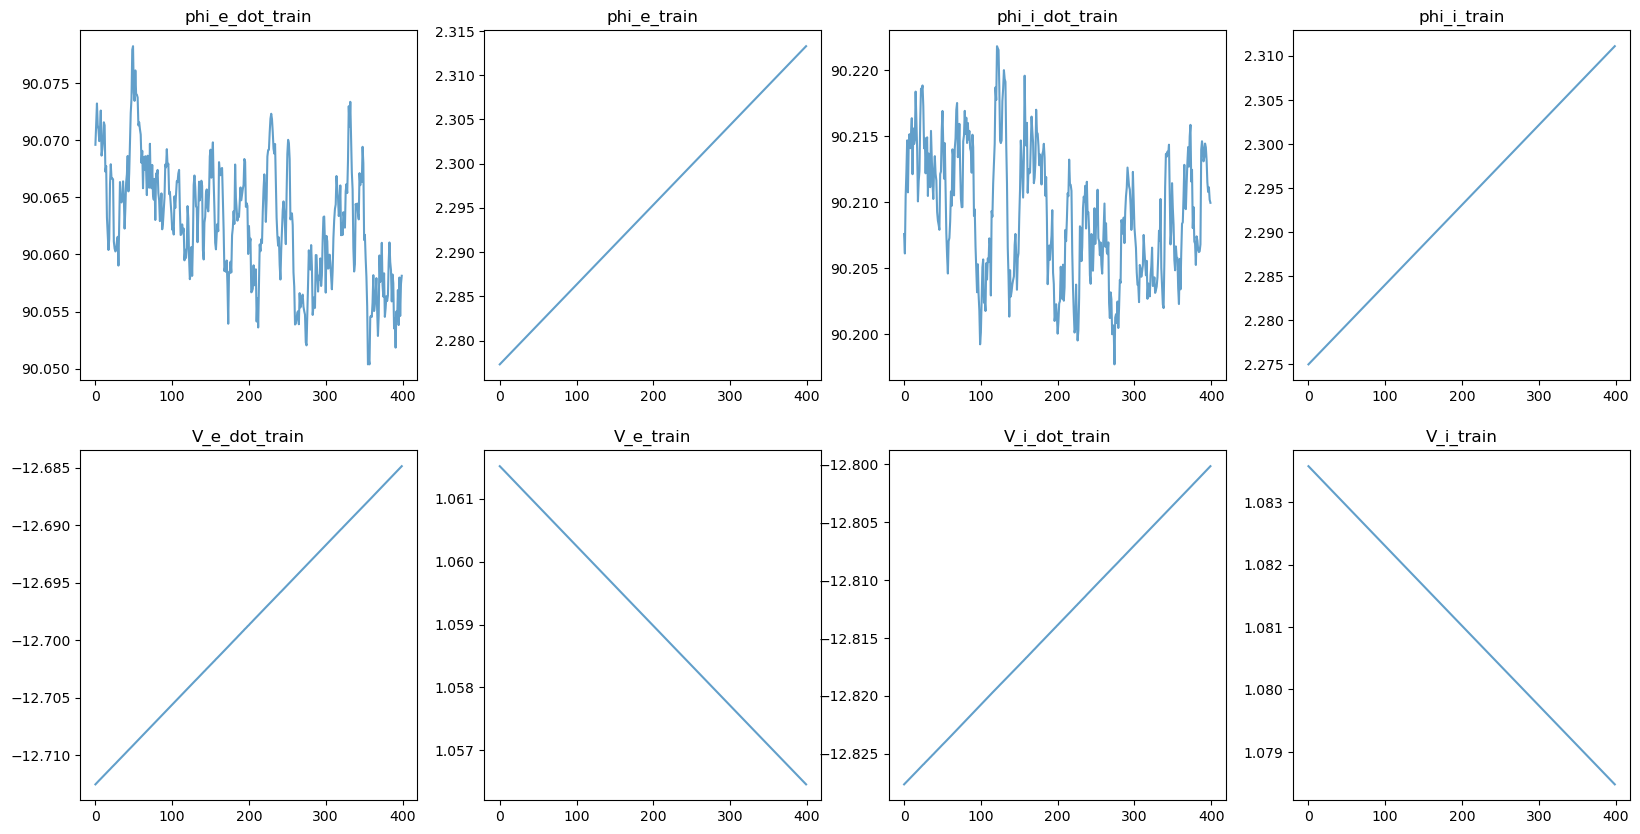

In [22]:
fig,axes=plt.subplots(ncols=4,nrows=2,figsize=(20, 10))
for n, param in enumerate(params_toplot):
    ax = axes.ravel()[n]
    ax.plot(getattr(F.output_sim,param).T.mean(axis=1), alpha=0.7)
    # plt.plot(eeg_data[i, :].T, label='data')
    ax.set(title=param)
    # ax.legend()
plt.show()


model test with 20 window for warmup



In [23]:
F.test(200, u=u)


FC_cor:  0.21678306936891195 cos_sim:  0.027794669419590058


Plot SC and fitted SC



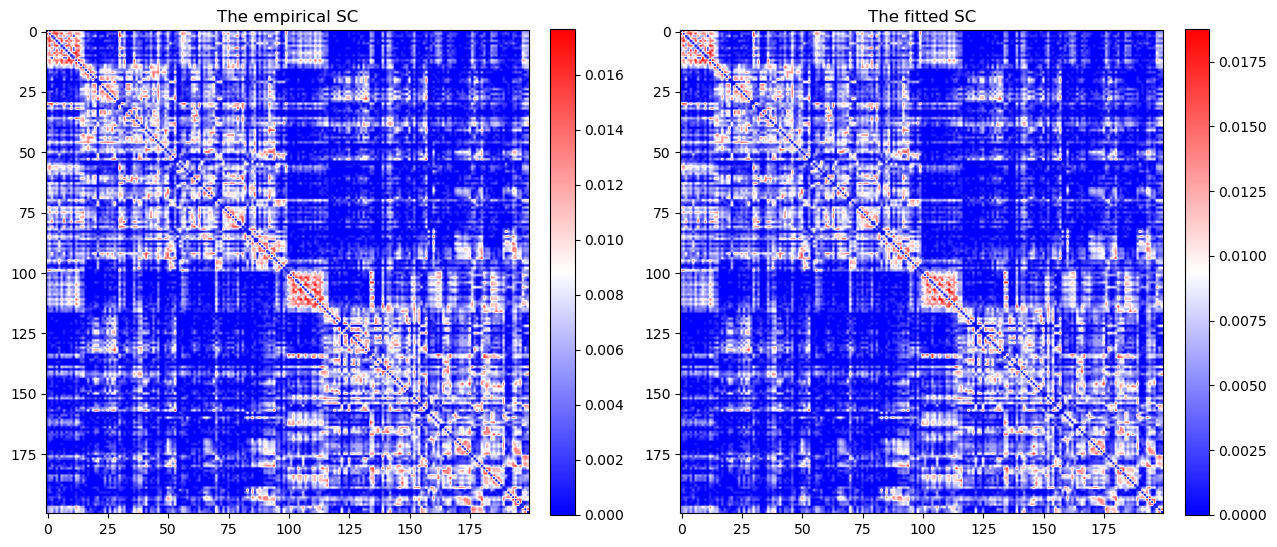

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
im0 = ax[0].imshow(sc, cmap='bwr')
ax[0].set_title('The empirical SC')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
im1 = ax[1].imshow(F.model.sc_fitted.detach().numpy(), cmap='bwr')
ax[1].set_title('The fitted SC')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
plt.show()


Plot the EEG



AttributeError: 'OutputNM' object has no attribute 'P_test'

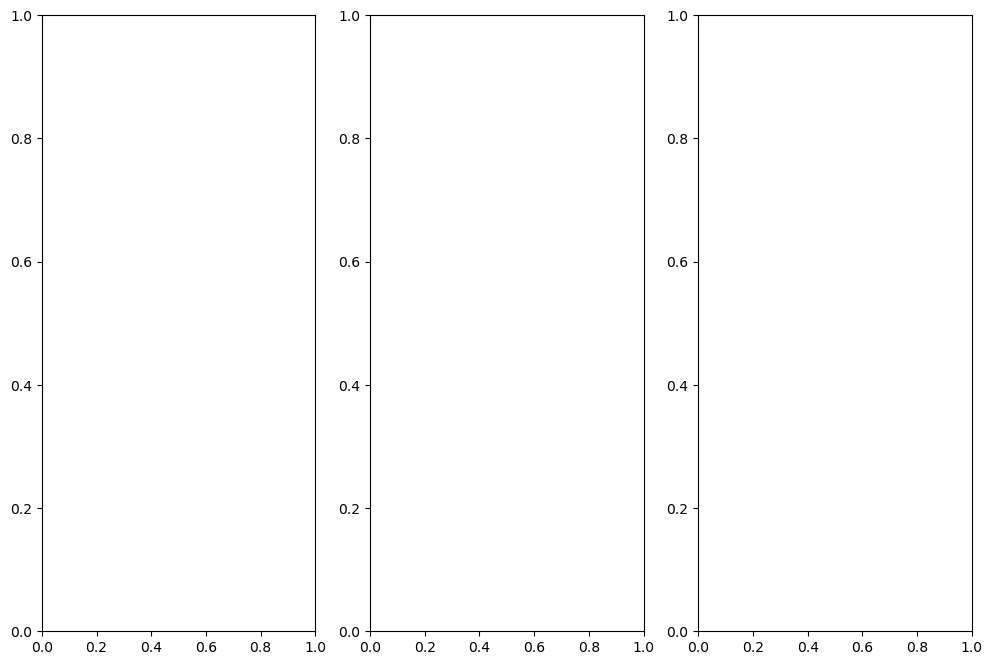

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].plot(F.output_sim.P_test.T)
ax[0].set_title('Test: sourced EEG')
ax[1].plot(F.output_sim.eeg_test.T)
ax[1].set_title('Test')
ax[2].plot(eeg_data.T)
ax[2].set_title('empirical')
plt.show()
